In [1]:
from os import environ
import pandas as pd
from rpc import RPC
from ranking_dataset import RankingDataset
from ranking_validation import RankingValidation

This notebook presents an application of non-linear dimensionality reduction Ranking Principal Curve fitting (https://arxiv.org/abs/1402.4542) to the ranking of Slovenian students having taken their Matura essay exams. We aggregate scores from six components of the exam into a single score. Intuitively, we could simply sum over the six component scores, but that would be boring. Plus, why not exploit information given by the shape of the data distributions unique to each year? If our data are not normally or uniformly distributed, then a straight line will not be the best-fitting line to our data. In another notebook, we show examples of PCA and several KernelPCA variants failing to produce even remotely useful rankings.

In [2]:
# our data set is taken from https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0195297.
# R was used to convert the original format into a CSV. Below, we load and preprocess the data.
matura_df = pd.read_csv("./matura_essay_scoring_dataset.csv").dropna()
matura_df.describe()

,Unnamed: 0,ID,ID_year,Score_Rater1,Score_Rater2,C_extra_1,C_extra_2,C_sum_1,C_sum_2,L_extra_1,L_extra_2,L_struct_1,L_struct_2,L_style_1,L_style_2,L_syntax_1,L_syntax_2
count,38910.000000,38910.000000,38910.000000,38910.000000,38910.000000,38910.000000,38910.000000,38910.000000,38910.000000,38910.000000,38910.000000,38910.000000,38910.000000,38910.000000,38910.000000,38910.000000,38910.000000
mean,23584.496068,120391.512336,11.859907,30.462092,30.095168,0.198098,0.175122,19.674582,19.274480,0.096942,0.098638,5.106322,5.116088,3.499974,3.520072,1.887355,1.911334
std,13616.066472,11770.665305,1.428259,7.433853,7.303449,0.532118,0.504133,5.139293,5.054715,0.375368,0.383265,1.016419,1.015982,1.362524,1.362112,1.935911,1.941789
min,1.000000,100001.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11822.250000,110200.250000,11.000000,26.000000,25.000000,0.000000,0.000000,16.000000,16.000000,0.000000,0.000000,5.000000,5.000000,3.000000,3.000000,0.000000,0.000000
50%,23623.500000,120374.500000,12.000000,31.000000,30.000000,0.000000,0.000000,20.000000,20.000000,0.000000,0.000000,5.000000,5.000000,4.000000,4.000000,1.000000,2.000000
75%,35359.750000,130556.750000,13.000000,35.000000,35.000000,0.000000,0.000000,23.000000,23.000000,0.000000,0.000000,6.000000,6.000000,5.000000,5.000000,3.000000,3.000000
max,47163.000000,140796.000000,14.000000,50.000000,50.000000,3.000000,3.000000,30.000000,30.000000,3.000000,3.000000,6.000000,6.000000,6.000000,6.000000,8.000000,8.000000


In [3]:
# we add a student ID field and convert hexadecimal rater IDs to base 10 to support multi-level/hierarchical
# modeling if desired
matura_df['ID'] = matura_df.index
matura_df['ID_Rater1'] = matura_df['ID_Rater1'].apply(lambda x: int(x, 16))
matura_df['ID_Rater2'] = matura_df['ID_Rater2'].apply(lambda x: int(x, 16))
matura_df.describe()

,Unnamed: 0,ID,ID_year,ID_Rater1,ID_Rater2,Score_Rater1,Score_Rater2,C_extra_1,C_extra_2,C_sum_1,C_sum_2,L_extra_1,L_extra_2,L_struct_1,L_struct_2,L_style_1,L_style_2,L_syntax_1,L_syntax_2
count,38910.000000,38910.000000,38910.000000,38910.000000,38910.000000,38910.000000,38910.000000,38910.000000,38910.000000,38910.000000,38910.000000,38910.000000,38910.000000,38910.000000,38910.000000,38910.000000,38910.000000,38910.000000,38910.000000
mean,23584.496068,19454.500000,11.859907,105068.465484,104864.626960,30.462092,30.095168,0.198098,0.175122,19.674582,19.274480,0.096942,0.098638,5.106322,5.116088,3.499974,3.520072,1.887355,1.911334
std,13616.066472,11232.493824,1.428259,27232.889003,27441.279744,7.433853,7.303449,0.532118,0.504133,5.139293,5.054715,0.375368,0.383265,1.016419,1.015982,1.362524,1.362112,1.935911,1.941789
min,1.000000,0.000000,10.000000,51635.000000,51635.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11822.250000,9727.250000,11.000000,109002.000000,109002.000000,26.000000,25.000000,0.000000,0.000000,16.000000,16.000000,0.000000,0.000000,5.000000,5.000000,3.000000,3.000000,0.000000,0.000000
50%,23623.500000,19454.500000,12.000000,119895.000000,119895.000000,31.000000,30.000000,0.000000,0.000000,20.000000,20.000000,0.000000,0.000000,5.000000,5.000000,4.000000,4.000000,1.000000,2.000000
75%,35359.750000,29181.750000,13.000000,121743.000000,121757.000000,35.000000,35.000000,0.000000,0.000000,23.000000,23.000000,0.000000,0.000000,6.000000,6.000000,5.000000,5.000000,3.000000,3.000000
max,47163.000000,38909.000000,14.000000,122456.000000,122456.000000,50.000000,50.000000,3.000000,3.000000,30.000000,30.000000,3.000000,3.000000,6.000000,6.000000,6.000000,6.000000,8.000000,8.000000


In [4]:
# for demo purposes, we arbitrarily sub-select just one year's data since test rubrics vary from year to year 
matura_year_10 = matura_df[matura_df["ID_year"] == 10]
matura_year_10.describe()

,Unnamed: 0,ID,ID_year,ID_Rater1,ID_Rater2,Score_Rater1,Score_Rater2,C_extra_1,C_extra_2,C_sum_1,C_sum_2,L_extra_1,L_extra_2,L_struct_1,L_struct_2,L_style_1,L_style_2,L_syntax_1,L_syntax_2
count,9107.000000,9107.000000,9107.0,9107.000000,9107.000000,9107.000000,9107.000000,9107.000000,9107.000000,9107.000000,9107.000000,9107.000000,9107.000000,9107.000000,9107.000000,9107.000000,9107.000000,9107.000000,9107.000000
mean,23742.758537,19585.106511,10.0,108644.454266,109078.307017,30.441309,30.045240,0.208082,0.188756,19.419567,19.076425,0.109037,0.099704,5.231251,5.225980,3.557483,3.551224,1.918305,1.904579
std,13645.548354,11256.863908,0.0,24480.241691,24111.568422,7.470253,7.302787,0.549213,0.519817,5.073584,4.980511,0.401338,0.387804,0.978294,1.006291,1.344252,1.321104,1.971720,1.960181
min,3.000000,2.000000,10.0,51892.000000,51892.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11859.000000,9760.500000,10.0,110837.000000,110842.000000,26.000000,26.000000,0.000000,0.000000,16.000000,16.000000,0.000000,0.000000,5.000000,5.000000,3.000000,3.000000,0.000000,0.000000
50%,23855.000000,19654.000000,10.0,120034.000000,120035.000000,31.000000,30.000000,0.000000,0.000000,20.000000,19.000000,0.000000,0.000000,5.000000,6.000000,4.000000,4.000000,1.000000,1.000000
75%,35623.500000,29400.000000,10.0,121766.000000,121766.000000,35.000000,35.000000,0.000000,0.000000,23.000000,23.000000,0.000000,0.000000,6.000000,6.000000,5.000000,5.000000,3.000000,3.000000
max,47148.000000,38898.000000,10.0,122430.000000,122430.000000,50.000000,50.000000,3.000000,3.000000,30.000000,30.000000,3.000000,3.000000,6.000000,6.000000,6.000000,6.000000,8.000000,8.000000


In [ ]:
# for demo purposes, we select scores from just one of the two raters for each student
matura_year_10_rater_1_df = matura_year_10[
    ["ID", "C_extra_1", "C_sum_1", "L_extra_1", "L_struct_1", "L_style_1", "L_syntax_1"]
].copy()

new_columns = ["ID", "C_extra", "C_sum", "L_extra", "L_struct", "L_style", "L_syntax"]
matura_year_10_rater_1_df.columns = new_columns

matura_year_10_rater_1_df.describe()

,ID,C_extra,C_sum,L_extra,L_struct,L_style,L_syntax
count,9107.000000,9107.000000,9107.000000,9107.000000,9107.000000,9107.000000,9107.000000
mean,19585.106511,0.208082,19.419567,0.109037,5.231251,3.557483,1.918305
std,11256.863908,0.549213,5.073584,0.401338,0.978294,1.344252,1.971720
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9760.500000,0.000000,16.000000,0.000000,5.000000,3.000000,0.000000
50%,19654.000000,0.000000,20.000000,0.000000,5.000000,4.000000,1.000000
75%,29400.000000,0.000000,23.000000,0.000000,6.000000,5.000000,3.000000
max,38898.000000,3.000000,30.000000,3.000000,6.000000,6.000000,8.000000


## Model construction and pre-fitting inspection

The response variable is a custom HurdleOrderedLogistic random variable. It fits our data better than the standard OrderedLogistic offered by the library because zeros in our data can significantly outnumber other ordinal values, causing the per-rubric distributions to have irregular shapes. The hurdle first predicts zero or non-zero using a logistic, then predicts the predicts the specific non-zero values using an ordered logistic.

In [6]:
# instantiate our dataset and ranking principal curve objects. The rpc model, once fit, will update 
# the dataset's dataframe with learned scores and ranks, and then sort student records by score/rank
dataset = RankingDataset(
    matura_year_10_rater_1_df,
    new_columns[1:]
)
# we implement ranking principal (bezier) curves of orders 1 through 7, and test a curve of order 3
# as a baseline before considering higher complexity, per https://arxiv.org/abs/1402.4542
rpc = RPC(
    dataset, 
    order=3,
    prior_sigma=15.,
    # use_hurdle=True,
    use_zero_inflation=True
    )

In [7]:
# Construct our PyMC model.
rpc.build()

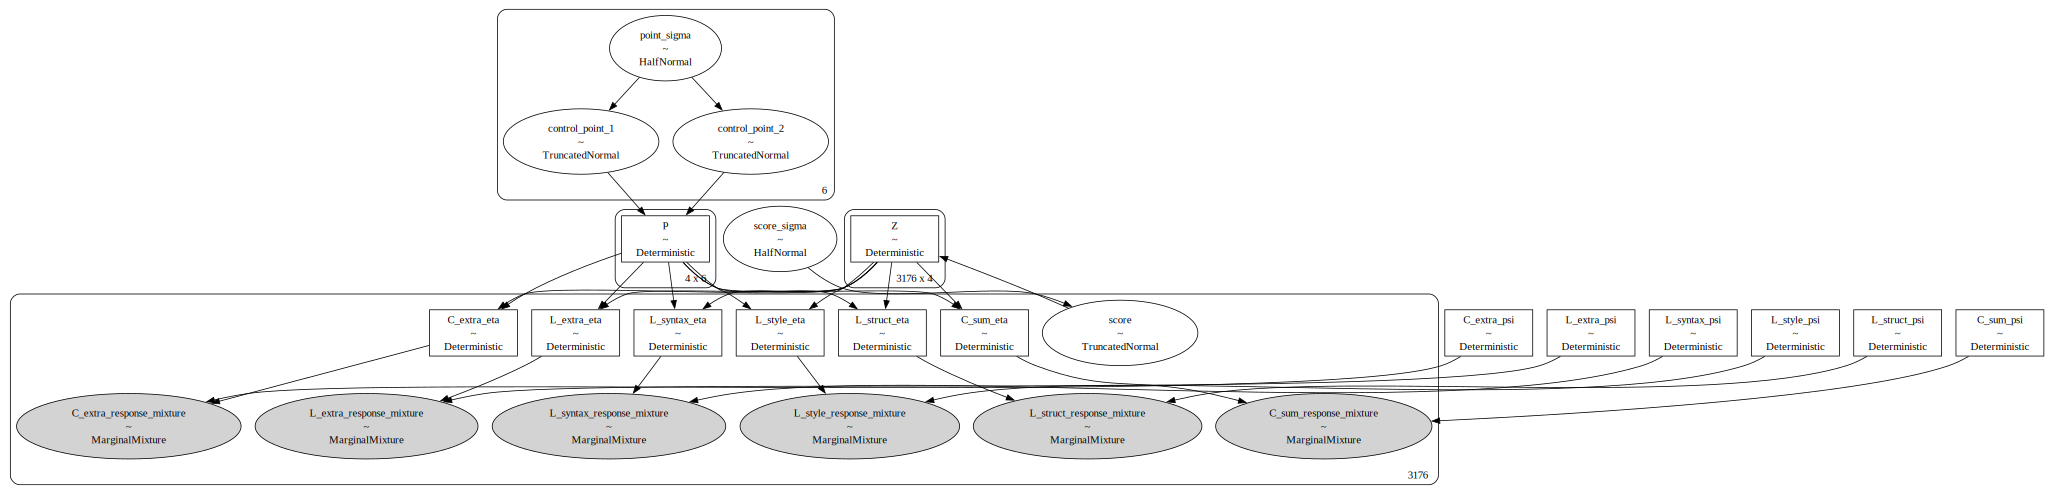

In [8]:
# verify that our model is structured as expected
rpc.model.to_graphviz()

Sampling: [C_extra_response_mixture, C_sum_response_mixture, L_extra_response_mixture, L_struct_response_mixture, L_style_response_mixture, L_syntax_response_mixture, control_point_1, control_point_2, point_sigma, score, score_sigma]


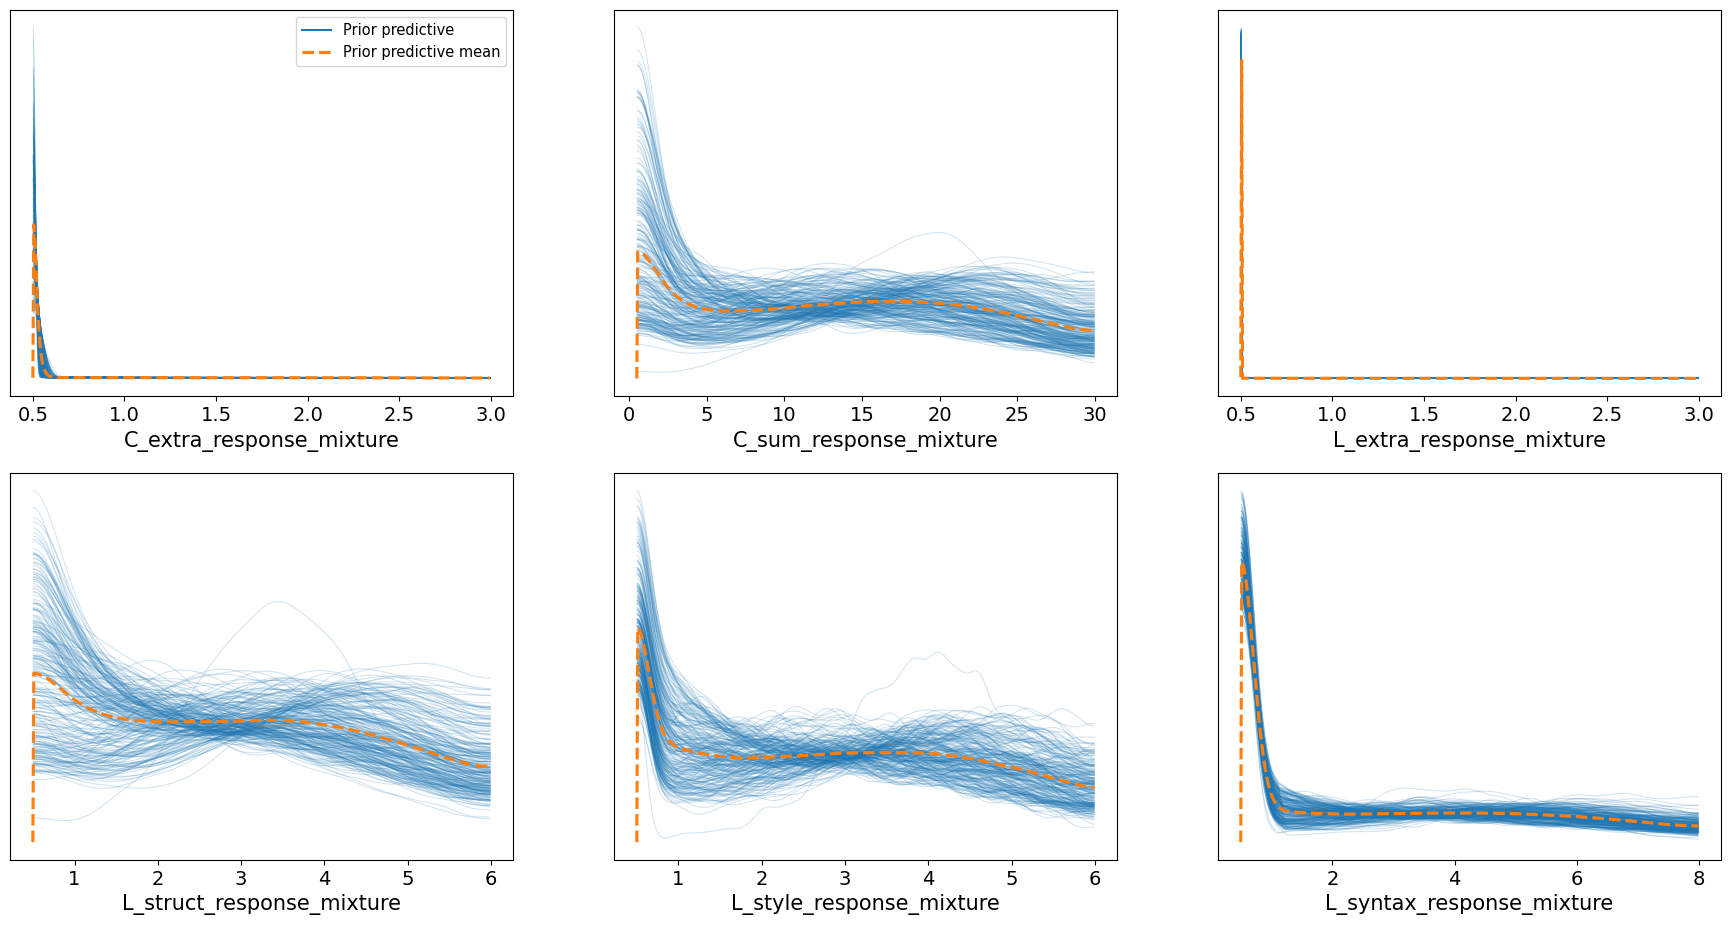

In [9]:
# sample from the prior distribution to verify that the 
# bounds on our attribute/rubric score values are correct
rpc.plot_prior_predictive(draws=250)

## Model fitting and result inspection

In [10]:
# we fit our model using the GPU-supporting JAX implementation 
# of the No U-Turn Hamiltonian Monte Carlo algorithm
environ["CUDA_VISIBLE_DEVICES"] = "0"

rpc.fit(
    tune=250,
    draws=250,
    chains=4,
    cores=4,
    target_accept=.98,
    nuts_sampler="pymc"
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'point_sigma_log__': array([3.08154492, 3.40220147, 2.75515622, 1.9610146 , 1.92336274,
       2.53065834]), 'control_point_1_interval__': array([-0.19476233, -0.00953514, -3.77883225, -5.07446236,  1.09455168,
        2.21134049]), 'control_point_2_interval__': array([ 1.24502207,  1.36106164,  0.18149827,  3.37599678,  1.45490078,
       -5.58848792]), 'score_sigma_log__': array(2.2775965), 'score_interval__': array([-34.48516508,  -1.45468267,  -1.06379622, ...,   2.01476486,
         0.54426197,   1.24038433])}

Logp initial evaluation results:
{'point_sigma': -6.12, 'control_point_1': -15.78, 'control_point_2': -15.87, 'score_sigma': -0.87, 'score': -5104.56, 'C_extra_response_mixture': -inf, 'C_sum_response_mixture': -inf, 'L_extra_response_mixture': -inf, 'L_struct_response_mixture': -inf, 'L_style_response_mixture': -inf, 'L_syntax_response_mixture': -inf}
You can call `model.debug()` for more details.

Sampling: [C_extra_response, C_sum_response, L_extra_response, L_struct_response, L_style_response, L_syntax_response]


Output()

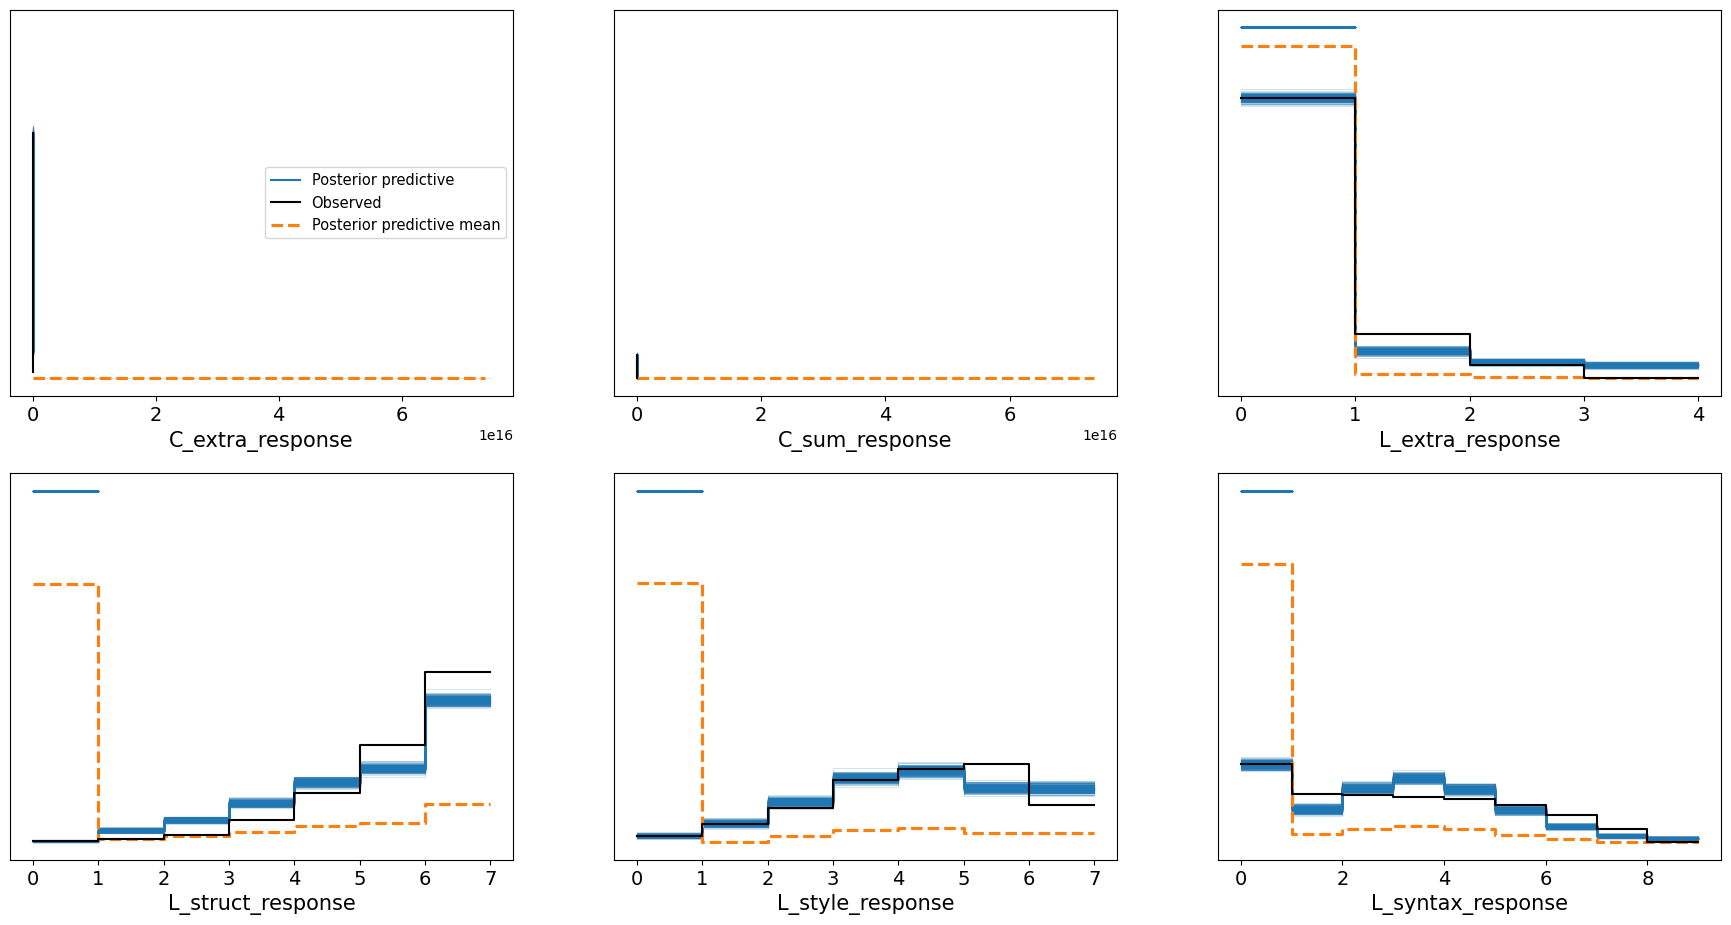

In [18]:
# let's see how well our fit model can reconstruct our input. In this unsupervised setting
# where we are interested only in summarizing our input data and not in making predictions
# given previously unseen future input data, it is not important to consider regularization
rpc.plot_posterior_predictive()

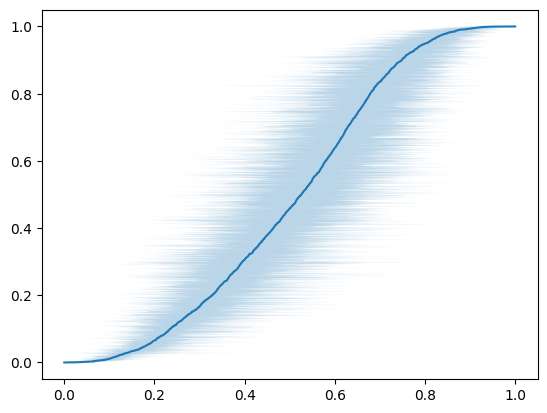

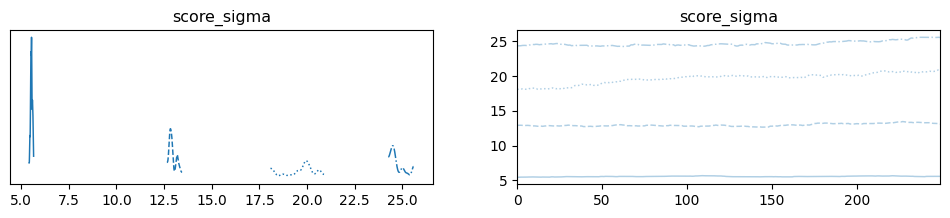

In [12]:
# here are mean and 94% high density intervals for our learned student scores, arrayed in order 
# of highest score along the x-axis. The second graphic shows a distribution over the plausible
# range of values that the "true" standard deviation of scores for each student may take. All
# scores share a single common std dev random variable
rpc.plot_posterior_score_traces()

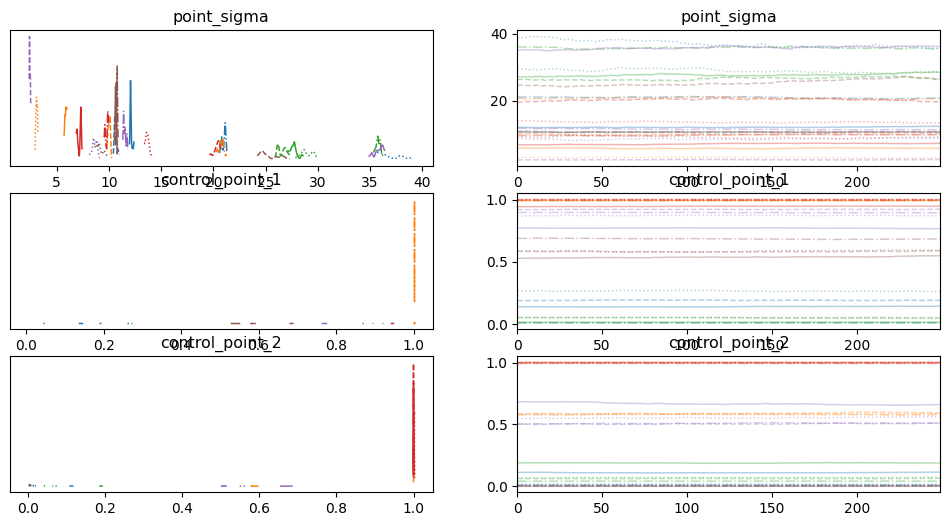

In [13]:
# plot the learned posteriors over our latent control points and their shared standard deviations 
# (shared across points withinig a single dimension). Recall from the RPC paper that a cubic bezier
# curve has four control points, with the initial endpoint anchored at zero and the terminal endpoint
# anchored at 1 in each dimension of the unit hypercube to enforce the constraint that the ranking
# curve be strictly monotonically increasing. So, in these plots we only see the middle two control 
# points. Dimensions share a common color-coding across plots.
rpc.plot_posterior_point_traces()

In [14]:
# one measure of the goodness of model fit is the PSIS-LOO-CV atatistical approximation 
# to leave-one-out cross-validation. The score, for which less negative is better, is 
# useful when comparing the fit of two models. One score in isolation is not meaningful
loo_score = rpc.get_loo_cross_validation()
loo_score

Output()

/home/ubuntu/anaconda3/envs/rastml/lib/python3.11/site-packages/arviz/stats/stats.py:1043: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/ubuntu/anaconda3/envs/rastml/lib/python3.11/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


KeyboardInterrupt: 

## Ranking Model Validation 

We define a novel validation procedure to measure the goodness of our ranking. The primary metric of interest is the Stuart's Tau correlation, which measures the correlation between two rankings of a single data set. A correlation of 1 means the rankings are identical. A coefficient of .5 or higher is considered highly correlated. One of .3 to .5 is somewhat correlated. And less than .3 is weakly correlated. Our goal is to show that the proximity of data points in the high-dimensional input space is consistent with their proximity in the one-dimensional score space. We do this by performing a multi-level clustering of the feature space, defining a ranking in that space based on the mean score of a cluster, and then comparing that ranking to the one given in the one-dimensional space by our model. The idea is that if a data point's nearby neighbors in the HD space have scores that are highly dissimilar from that point's score, then the mean score associated with that point will be dragged away from it (up or down), creating conditions wherein data points from far away clusters that have (for example) lower scores will a higher mean than that subject data point, creating discordances that will lower the Stuart's Tau correlation coefficient.

We use a multi-level clustering because data points belonging to disparate regions of the high-dimensional space will necessarily overlap/intersect in the one-dimensional space. We want to collapse overlapping "level 1" clusters into "level 2" before assigning score mean-based ranks by clustering them. level 1 clusters are defined/represented by the mean, lower percentile (e.g. 5%), upper percentile (e.g. 95%) and standard deviation of the scores within them.

In [25]:
# create our validation object and compute metrics that we will use to judge the quality of our ranking
rv = RankingValidation(
    dataset=rpc.dataset,
    score_name=rpc.score_name,
    rank_name=rpc.rank_name,
    attribute_labels=rpc.attribute_labels
)
rm = rv.get_ranking_metrics(max_num_l1_clusters=404)

Because we do not know which clustering algorithm and algorithm parameterization will yield the best comparison of 1D versus HD neighborhoods, we perform a grid search over a range of algorithms and parameters, and consider a collection of outputs. 

In [45]:
# lets print out our metrics.
to_print = [
    "cluster_id: ({}, {}), stuart_tau: ({:01.5f}, {:01.5f}), l2_silhouette: {:01.5f}, l2_average_std_dev: {:01.5f}".format(
        *v["stuart_tau"][2:], *v["stuart_tau"][:2], v["l2_silhouette"], v["l2_average_std_dev"]
        ) for k, v in dict(reversed(sorted(
            rm.items(), 
            key=lambda item: (-item[1]["l2_average_std_dev"], (item[1]["stuart_tau"][0] + item[1]["l2_silhouette"]) / item[1]["l2_average_std_dev"]))
            )).items()
            ]

to_print

['cluster_id: (401, 7), stuart_tau: (0.41454, 0.00000), l2_silhouette: 0.41737, l2_average_std_dev: 0.04441',
 'cluster_id: (399, 8), stuart_tau: (0.42574, 0.00000), l2_silhouette: 0.42130, l2_average_std_dev: 0.04521',
 'cluster_id: (394, 6), stuart_tau: (0.46618, 0.00000), l2_silhouette: 0.43033, l2_average_std_dev: 0.04591',
 'cluster_id: (384, 4), stuart_tau: (0.56243, 0.00000), l2_silhouette: 0.49295, l2_average_std_dev: 0.04597',
 'cluster_id: (389, 10), stuart_tau: (0.55989, 0.00000), l2_silhouette: 0.42347, l2_average_std_dev: 0.04607',
 'cluster_id: (387, 4), stuart_tau: (0.56505, 0.00000), l2_silhouette: 0.50064, l2_average_std_dev: 0.04667',
 'cluster_id: (393, 5), stuart_tau: (0.44941, 0.00000), l2_silhouette: 0.47744, l2_average_std_dev: 0.04688',
 'cluster_id: (366, 5), stuart_tau: (0.47968, 0.00000), l2_silhouette: 0.47644, l2_average_std_dev: 0.04696',
 'cluster_id: (377, 6), stuart_tau: (0.41167, 0.00000), l2_silhouette: 0.44108, l2_average_std_dev: 0.04709',
 'cluster

There is no perfect single number that summarizes a clustering's  full story! ...but, one idea is to compute (stuart_tau + silhouette) / std_dev. For now, we prioritize the average standard deviation across level 2 clusters to make for pretty visualizations

So... lets pick some good looking metrics and derive some visualizations from them! Below, we'll see three plots with cluster ids on the y-axis, rank order on the x-axis, and color-coded clusters with means and percentiles marked, and with clusters being ordered by their score mean.

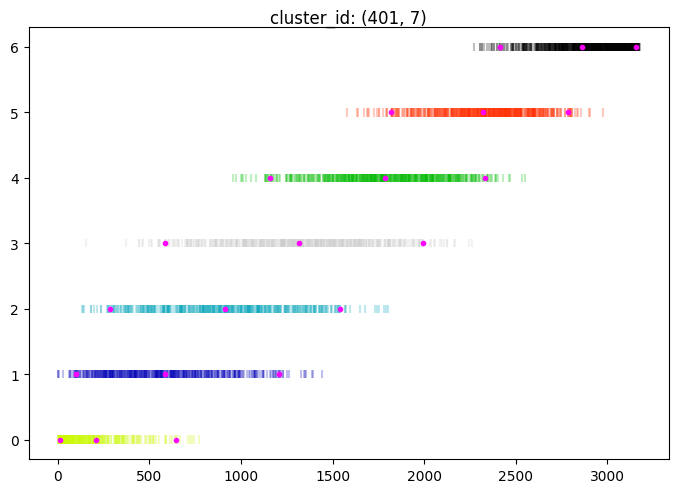

In [46]:
# plot a 2-level clustering per our choice of interesting metrics
rv.visualize_l2_clusters(401, 7)

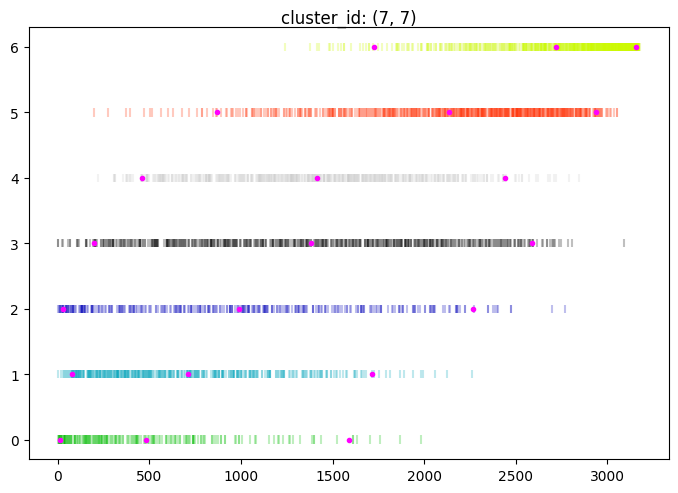

In [47]:
# if we were to partition the HD space into N clusters directly, without 
# using hierarchy, what would our plot look like?
rv.visualize_l1_clusters(7)

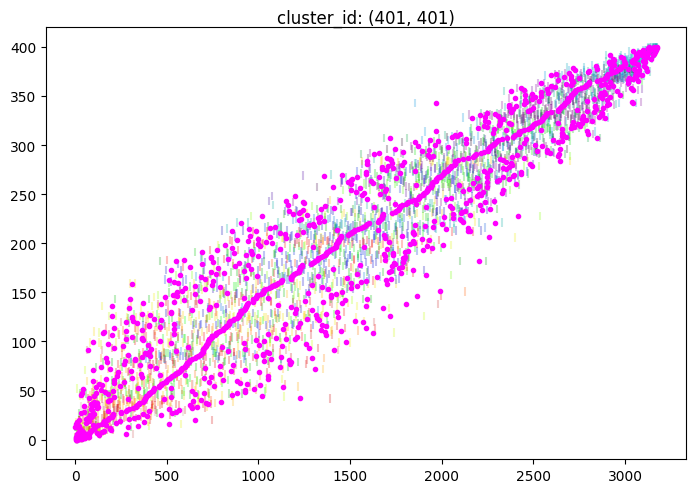

In [48]:
# here's a plot of the level one clusters that yielded our glorious metric values at level 2
rv.visualize_l1_clusters(401)